In [1]:
PREAMBLE = '''"""RASP programs only using the subset of RASP supported by the compiler."""

from typing import List, Sequence
import math

from tracr.rasp import rasp
from tracr.compiler.lib import *

'''

from tqdm import tqdm
import numpy as np 
from typing import List, Sequence
import math
import os 
import sys
from threading import Thread
import logging

from tracr.compiler import compiling
from tracr.rasp import rasp
from tracr.compiler.lib import *

import jax
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns 
import haiku as hk

# The default of float16 can lead to discrepancies between outputs of
# the compiled model and the RASP program.
jax.config.update('jax_default_matmul_precision', 'float32')

from tracr.compiler import lib
from tracr.rasp import rasp
from tracr.compiler import compiling

logging.basicConfig(level=logging.ERROR)

PROGRAM_TEMPLATE = '''def make_program_{program_id}() -> rasp.SOp: '''

MAP_OPS_LIB = [
    'lambda x: -x', 'math.sin', 'math.cos', 'math.tan',
    'lambda x: x ** 2', 'lambda x: x ** 0.5', 'lambda x: abs(x)', 'math.log', 'lambda x: 1 / (x + 1e-5)',
    'lambda x: x + 1', 'lambda x: x - 1', 'lambda x: 2 * x', 'lambda x: x / 2', 'lambda x: x % 2',
    'math.atan', 'math.ceil', 'math.floor',
    'lambda x: round(x)', 'lambda x: x ** 1.5', 'lambda x: 1.1 ** x', 'math.sqrt', 'lambda x: x * -1',
    'lambda x: x / 3', 'lambda x: x * 5', 'lambda x: x - 5', 'lambda x: x // 2', 'lambda x: x % 3',
]

SELECT_OPS_LIB = [
    'rasp.Comparison.TRUE', 'rasp.Comparison.FALSE', 'rasp.Comparison.EQ', 'rasp.Comparison.LEQ', 'rasp.Comparison.GEQ',
    'rasp.Comparison.LT', 'rasp.Comparison.GT', 'rasp.Comparison.NEQ',
]

SMAP_OPS_LIB = [
    'lambda x, y: x + y',
    'lambda x, y: x - y',
    'lambda x, y: x * y',
    'lambda x, y: x / (y + 1) if y != -1 else 0',  # Avoid division by zero
    'lambda x, y: 0 if x == y else 1',
    'lambda x, y: (2 * x + y) / 2',
    'lambda x, y: (x + y) / 2',
    'lambda x, y: min(x, y)',
    'lambda x, y: max(x, y)',
    'lambda x, y: x % y if y else 0',  # Avoid division by zero
    'lambda x, y: y % x if x else 0',  # Avoid division by zero
    'lambda x, y: abs(x - y)',
    'lambda x, y: min((x**2 + y**2)**0.5, 10**5)',  # Limit the result to avoid overflow
    'lambda x, y: min((x * y)**0.5, 10**5)',  # Limit the result to avoid overflow
    'lambda x, y: min((x * y) ** 0.5, 10**5)',  # Limit the result to avoid overflow
    'lambda x, y: 1 / (x + y) if x + y else 0',  # Avoid division by zero
    'lambda x, y: 2 * x + 3 * y',
    'lambda x, y: x / (y + 1) if y != -1 else 0',  # Avoid division by zero
    'lambda x, y: y / (x + 1) if x != -1 else 0',  # Avoid division by zero
    'lambda x, y: (x + y) / (x - y + 1) if x != y - 1 else 0',  # Avoid division by zero
    'lambda x, y: (x - y) / (x + y + 1) if x + y != -1 else 0',  # Avoid division by zero
    'lambda x, y: min((x * x + y * y) ** 0.5, 10**5)',  # Limit the result to avoid overflow
    'lambda x, y: x * x - y * y',
    'lambda x, y: min((x + y) ** 1.1, 10**5)',  # Limit the result to avoid overflow
    'lambda x, y: min((x - y) ** 1.1, 10**5)',  # Limit the result to avoid overflow
    'lambda x, y: min(x ** 1.1 + y ** 1.1, 10**5)',  # Limit the result to avoid overflow
    'lambda x, y: min(x ** 1.1 - y ** 1.1, 10**5)'  # Limit the result to avoid overflow
]


In [2]:
# def write_select(i1, i2, func, var_name): 
#     write = ''
#     write += f'\n   {var_name} = rasp.Select({i1}, {i2}, {func})'
#     aggregation_op = np.random.choice(['aggregate', 'selectorwidth'])
#     if aggregation_op == 'aggregate': 
#         aggergation_i = np.random.choice([i1, i2])
#         write += f'\n   {var_name} = rasp.Aggregate({var_name}, {aggergation_i}).named("{var_name}")'
#     elif aggregation_op == 'selectorwidth':
#         write += f'\n   {var_name} = rasp.SelectorWidth({var_name}).named("{var_name}")'
#     return write

# def generate_categorical_programs(N, max_ops, program_template, select_ops_lib, map_ops_lib, smap_ops_lib, seed): 
#     """
#     """
#     np.random.seed(seed)
#     for n in range(N): 
#         program = program_template
#         num_ops = np.random.randint(1, max_ops + 1)
#         avail_vars = ['rasp.tokens', 'rasp.indices']
#         for j in range(num_ops): 
#             var_name = f't_{j}'
#             if len(avail_vars) == 2: 
#                 # collapse 
#                 i1, i2 = avail_vars.pop(), avail_vars.pop()
#                 op = np.random.choice(['select', 'smap'])
#                 if op == 'select': 
#                     func = np.random.choice(select_ops_lib)
#                     program += write_select(i1, i2, func, var_name)
#                 elif op == 'smap': 
#                     func = np.random.choice(smap_ops_lib)
#                     program += f'\n   {var_name} = rasp.SequenceMap({func}, {i1}, {i2}).named("{var_name}")'
#                 avail_vars.append(var_name)
#             else: 
#                 add_new_var = np.random.rand() < 0.5
#                 i1 = avail_vars.pop()
#                 op = np.random.choice(['map', 'select'])
#                 if op == 'map': 
#                     func = np.random.choice(map_ops_lib)
#                     program += f'\n   {var_name} = rasp.Map({func}, {i1}).named("{var_name}")'
#                 elif op == 'select': 
#                     func = np.random.choice(select_ops_lib)
#                     program += write_select(i1, i1, func, var_name)
#                 # elif op == 'smap': 
#                 #     func = np.random.choice(smap_ops_lib)
#                 #     program += f'\n   {var_name} = rasp.SequenceMap({func}, {i1}, {i1}).named("{var_name}")'
#                 avail_vars.append(var_name)
#                 if add_new_var: 
#                     avail_vars.append(i1)
#         program += f'\n   return {var_name}'
#         yield program

In [3]:
# N = 10
# MAX_OPS = 10
# seed = 0
# programs_gen = generate_categorical_programs(N, MAX_OPS, PROGRAM_TEMPLATE, SELECT_OPS_LIB, MAP_OPS_LIB, SMAP_OPS_LIB, seed)

# # check if file exists
# if not os.path.exists("generated_categorical_lib.py"):
#     with open("generated_categorical_lib.py", "w") as file:
#         file.write(PREAMBLE)

# max_i = max([-1] + [int(line.split('make_program_')[1].split('()')[0]) for line in open("generated_categorical_lib.py", "r") if " = make_program_" in line])

# vocab = {0,1,2,3,4,5,6,7,8,9}
# max_seq_len = 10

# def compile_and_test_program(program_def, vocab, max_seq_len, flag_dict, i, max_i):
#     try:
#         compiled_model = compiling.compile_rasp_to_model(
#             program=program_def,
#             vocab=vocab,
#             max_seq_len=max_seq_len,
#             causal=False,
#             compiler_bos="bos",
#             compiler_pad="pad",
#             mlp_exactness=100)
#         print(compiled_model.apply(["bos", 0,1,2,3,4,5,6,7,8,9]).decoded)
#         flag_dict["completed"] = True
#     except Exception as e:
#         print(e)

# with open('generated_categorical_lib.py', 'a') as file:
    
#     file_program_id = max_i + 1
#     for i, program_def in enumerate(tqdm(programs_gen)):
#         flag = {"completed": False}
#         program_def = program_def.format(program_id=file_program_id)  # Use file_program_id here
#         exec(program_def + f'\n\nto_exec = make_program_{file_program_id}()')

#         thread = Thread(target=compile_and_test_program, args=(to_exec, vocab, max_seq_len, flag, i, max_i))
#         thread.start()
#         thread.join(timeout=30)  # Timeout of 30 seconds

#         if flag["completed"]:
#             program_def = program_def + '\n\n' + f'program_{file_program_id} = make_program_{file_program_id}()\n\n'
#             print('WRITING')
#             file.write(program_def)
#             file.flush()
#             os.fsync(file.fileno())
#             file_program_id += 1

#         else:
#             print(f"Generated program {file_program_id} either had an error or timed out.")

0it [00:00, ?it/s]

1it [00:02,  2.09s/it]

['bos', 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
WRITING


2it [00:04,  2.02s/it]

['bos', 9, 9, 9, 9, 9, 9, 9, 9, 9, 9]
WRITING


3it [00:11,  4.27s/it]

['bos', 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
WRITING


4it [00:12,  3.14s/it]

['bos', 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
WRITING


5it [00:14,  2.60s/it]

['bos', 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
WRITING


5it [00:44,  8.82s/it]


NameError: name 'program_file_id' is not defined

In [2]:
# test_cases = '''from tracr.datasets import generated_categorical_lib

# # Note that expected_output for each of these cases is empty 
# # Will fail pytest which is expected

# GENERATED_CATEGORICAL_LIB_TEST_CASES = ['''

# for i in range(N): 
#     test_cases += f'''
#     dict(
#         testcase_name="program_{i}_simple",
#         program=generated_categorical_lib.program_{i},
#         vocab={{0,1,2,3,4,5,6,7,8,9}},
#         test_input=[0,1,2,3,4,5,6,7,8,9],
#         expected_output=[],
#         max_seq_len=10,
#     ),'''
#     # test_cases += f'''
#     # dict(
#     #     testcase_name="program_{i}_simple_2",
#     #     program=generated_categorical_lib.program_{i},
#     #     vocab={{0,1,2,3,4,5,6,7,8,9}},
#     #     test_input=[9,8,7,6,5,4,3,2,1,0],
#     #     expected_output=[],
#     #     max_seq_len=10,
#     # ),'''
#     # test_cases += f'''
#     # dict(
#     #     testcase_name="program_{i}_simple_3",
#     #     program=generated_categorical_lib.program_{i},
#     #     vocab={{0,1,2,3,4,5,6,7,8,9}},
#     #     test_input=[0], # empty input
#     #     expected_output=[],
#     #     max_seq_len=10,
#     # ),'''
# test_cases += '\n]'

# with open('generated_test_cases.py', 'w') as file:
#     file.write(test_cases)

## test diversity

In [52]:
from tracr.datasets import generated_lib

vocab = {0,1,2,3,4,5,6,7,8,9}
max_seq_len = 10

def lex_ord_to_seq(lex_ord, max_seq_len): 
    assert lex_ord < 10**max_seq_len and lex_ord >= 0
    seq = []
    for i in range(max_seq_len): 
        seq.append(lex_ord % 10)
        lex_ord = lex_ord // 10
    return seq

def seq_to_lex_ord(seq, max_seq_len): 
    assert len(seq) == max_seq_len
    lex_ord = 0
    for i in range(max_seq_len): 
        lex_ord += seq[i] * 10**i
    return lex_ord

num_samples = 10**3
samples = []
for i in range(num_samples): 
    r = np.random.randint(0, 10**10)
    samples.append(r)

compiled_model = compiling.compile_rasp_to_model(
            program=generated_lib.program_1,
            vocab=vocab,
            max_seq_len=max_seq_len,
            causal=False,
            compiler_bos="bos",
            compiler_pad="pad",
            mlp_exactness=100)

error_programs = []
outputs = []
for sample in tqdm(samples): 
    seq = lex_ord_to_seq(sample, max_seq_len)
    out = compiled_model.apply(["bos"] + seq).decoded[1:]
    try: 
        out = [int(o) for o in out]
    except: 
        error_programs.append((1, sample))
        continue
    outputs.append(seq_to_lex_ord(out, max_seq_len))

expected_per_bin = num_samples / 100
print(expected_per_bin)
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(20, 10))
sns.histplot(samples, bins=100, ax=ax1)
ax1.axhline(expected_per_bin, color='r', linestyle='--')
ax1.set_title('Expected distribution of samples')
sns.histplot(outputs, bins=100, ax=ax2)
ax2.axhline(expected_per_bin, color='r', linestyle='--')
ax2.set_title('Actual distribution of outputs')
plt.show()

  1%|▏         | 13/1000 [00:02<03:13,  5.09it/s]


KeyboardInterrupt: 

In [53]:
generated_lib.__all__

AttributeError: module 'tracr.datasets.generated_lib' has no attribute '__all__'

In [5]:
#@title Plotting functions
def tidy_label(label, value_width=5):
  if ':' in label:
    label, value = label.split(':')
  else:
    value = ''
  return label + f":{value:>{value_width}}"

def add_residual_ticks(model, value_width=5, x=False, y=True):
  if y:
    plt.yticks(
            np.arange(len(model.residual_labels))+0.5, 
            [tidy_label(l, value_width=value_width)
              for l in model.residual_labels], 
            family='monospace',
            fontsize=20,
    )
  if x:
    plt.xticks(
            np.arange(len(model.residual_labels))+0.5, 
            [tidy_label(l, value_width=value_width)
              for l in model.residual_labels], 
            family='monospace',
            rotation=90,
            fontsize=20,
    )

def plot_computation_trace(model,
                           input_labels,
                           residuals_or_outputs,
                           add_input_layer=False,
                           figsize=(12, 9)):
  fig, axes = plt.subplots(nrows=1, ncols=len(residuals_or_outputs), figsize=figsize, sharey=True)
  value_width = max(map(len, map(str, input_labels))) + 1

  for i, (layer, ax) in enumerate(zip(residuals_or_outputs, axes)):
    plt.sca(ax)
    plt.pcolormesh(layer[0].T, vmin=0, vmax=1)
    if i == 0:
      add_residual_ticks(model, value_width=value_width)
    plt.xticks(
        np.arange(len(input_labels))+0.5,
        input_labels,
        rotation=90,
        fontsize=20,
    )
    if add_input_layer and i == 0:
      title = 'Input'
    else:
      layer_no = i - 1 if add_input_layer else i
      layer_type = 'Attn' if layer_no % 2 == 0 else 'MLP'
      title = f'{layer_type} {layer_no // 2 + 1}'
    plt.title(title, fontsize=20)


def plot_residuals_and_input(model, inputs, figsize=(12, 9), pca=None): 
  """Applies model to inputs, and plots the residual stream at each layer."""
  model_out = model.apply(inputs)
  residuals = np.concatenate([model_out.input_embeddings[None, ...],
                              model_out.residuals], axis=0)
  print(residuals.shape)
  if pca is not None: 
    old = residuals.shape[:-1]
    residuals = pca.transform(residuals.reshape(-1, residuals.shape[-1])).reshape(old + (-1,))
    print(residuals.shape)
  plot_computation_trace(
      model=model,
      input_labels=inputs,
      residuals_or_outputs=residuals,
      add_input_layer=True,
      figsize=figsize)


def plot_layer_outputs(model, inputs, figsize=(12, 9)):
  """Applies model to inputs, and plots the outputs of each layer."""
  model_out = model.apply(inputs)
  plot_computation_trace(
      model=model,
      input_labels=inputs,
      residuals_or_outputs=model_out.layer_outputs,
      add_input_layer=False,
      figsize=figsize)


## numerical lib code

In [ ]:
# def write_select(i1, i2, func, var_name): 
#     write = ''
#     write += f'\n   {var_name} = rasp.numerical(rasp.Select(rasp.categorical({i1}), rasp.categorical({i2}), {func}))'
#     aggregation_op = np.random.choice(['aggregate', 'selectorwidth'])
#     if aggregation_op == 'aggregate': 
#         aggergation_i = np.random.choice([i1, i2])
#         write += f'\n   {var_name} = rasp.numerical(rasp.Aggregate({var_name}, rasp.numerical({aggergation_i}), default=0)).named("{var_name}")'
#     elif aggregation_op == 'selectorwidth':
#         write += f'\n   {var_name} = rasp.numerical(rasp.SelectorWidth({var_name})).named("{var_name}")'
#     return write

# def generate_numerical_programs(N, max_ops, program_template, select_ops_lib, map_ops_lib, smap_ops_lib, seed): 
#     """
#     """
#     np.random.seed(seed)
#     for n in range(N): 
#         num_ops = np.random.randint(1, max_ops + 1)
#         program = program_template.format(program_id=n)
#         avail_vars = ['sop', 'indices']
#         for j in range(num_ops): 
#             var_name = f't_{j}'
#             if len(avail_vars) == 2: 
#                 # collapse 
#                 i1, i2 = avail_vars.pop(), avail_vars.pop()
#                 op = np.random.choice(['select'])
#                 if op == 'select': 
#                     func = np.random.choice(select_ops_lib)
#                     program += write_select(i1, i2, func, var_name)
#                 elif op == 'smap': 
#                     func = np.random.choice(smap_ops_lib)
#                     program += f'\n   {var_name} = rasp.SequenceMap({func}, {i1}, {i2}).named("{var_name}")'
#                 avail_vars.append(var_name)
#             else: 
#                 add_new_var = np.random.rand() < 0.5
#                 i1 = avail_vars.pop()
#                 op = np.random.choice(['map', 'select'])
#                 if op == 'map': 
#                     func = np.random.choice(map_ops_lib)
#                     program += f'\n   {var_name} = rasp.numerical(rasp.Map({func}, {i1})).named("{var_name}")'
#                 elif op == 'select': 
#                     func = np.random.choice(select_ops_lib)
#                     program += write_select(i1, i1, func, var_name)
#                 elif op == 'smap': 
#                     func = np.random.choice(smap_ops_lib)
#                     program += f'\n   {var_name} = rasp.SequenceMap({func}, {i1}, {i1}).named("{var_name}")'
#                 avail_vars.append(var_name)
#                 if add_new_var: 
#                     avail_vars.append(i1)
#         program += f'\n   return {var_name}'
#         yield program

# N = 100
# MAX_OPS = 10
# seed = 0
# programs_gen = generate_numerical_programs(N, MAX_OPS, PROGRAM_TEMPLATE, SELECT_OPS_LIB, MAP_OPS_LIB, SMAP_OPS_LIB, seed)
# file = open("generated_numerical_lib.py", "w")

# with open('generated_numerical_lib.py', 'w') as file:
#     file.write(PREAMBLE)

#     for i,program in enumerate(tqdm(programs_gen)):
#         file.write(program)
#         file.write('\n\n')
#         file.write(f'program_{i} = make_program_{i}(rasp.tokens)')
#         file.write('\n\n')
    

In [ ]:
# test_cases = '''from tracr.datasets import generated_numerical_lib

# # Note that expected_output for each of these cases is empty 
# # Will fail pytest which is expected

# GENERATED_NUMERICAL_LIB_TEST_CASES = ['''

# for i in range(N): 
#     """
#     dict(
#         testcase_name="token_position_encoding_simple",
#         program=generated_lib.make_token_position_encoding(),
#         vocab={"a", "b", "c", "d"},
#         test_input=["a", "b", "c", "d"],
#         expected_output=[(0, 3), (1, 2), (2, 1), (3, 0)],
#         max_seq_len=4,
#     ),"""
#     test_cases += f'''
#     dict(
#         testcase_name="program_{i}_simple",
#         program=generated_numerical_lib.program_{i},
#         vocab={{0,1,2,3,4,5,6,7,8,9}},
#         test_input=[0,1,2,3,4,5,6,7,8,9],
#         expected_output=[],
#         max_seq_len=10,
#     ),'''
#     test_cases += f'''
#     dict(
#         testcase_name="program_{i}_simple_2",
#         program=generated_numerical_lib.program_{i},
#         vocab={{0,1,2,3,4,5,6,7,8,9}},
#         test_input=[9,8,7,6,5,4,3,2,1,0],
#         expected_output=[],
#         max_seq_len=10,
#     ),'''
#     test_cases += f'''
#     dict(
#         testcase_name="program_{i}_simple_3",
#         program=generated_numerical_lib.program_{i},
#         vocab={{0,1,2,3,4,5,6,7,8,9}},
#         test_input=[0], # empty input
#         expected_output=[],
#         max_seq_len=10,
#     ),'''
# test_cases += '\n]'

# with open('generated_test_cases.py', 'w') as file:
#     file.write(test_cases)

## test diversity

In [1]:
# import pickle
# import os


# with open(os.path.abspath('../examples/data2/outputs.pkl'), 'rb') as file:
#     outputs2 = pickle.load(file)

# with open(os.path.abspath('../examples/data1/outputs.pkl'), 'rb') as file:
#     outputs1 = pickle.load(file)

# with open(os.path.abspath('../examples/data3/outputs.pkl'), 'rb') as file:
#     outputs3 = pickle.load(file)

# with open(os.path.abspath('../examples/data1/samples.pkl'), 'rb') as file:
#     samples = pickle.load(file)

# with open(os.path.abspath('../examples/data2/samples.pkl'), 'rb') as file:
#     samples2 = pickle.load(file)

# with open(os.path.abspath('../examples/data3/samples.pkl'), 'rb') as file:
#     samples3 = pickle.load(file)

# with open(os.path.abspath('../examples/data1/not_numerical_ids.pkl'), 'rb') as file:
#     not_numerical_idxs1 = pickle.load(file)

# with open(os.path.abspath('../examples/data2/not_numerical_ids.pkl'), 'rb') as file:
#     not_numerical_idxs2 = pickle.load(file)

# with open(os.path.abspath('../examples/data3/not_numerical_ids.pkl'), 'rb') as file:
#     not_numerical_idxs3 = pickle.load(file)

# with open(os.path.abspath('../examples/data1/out_of_range_ids.pkl'), 'rb') as file:
#     out_of_range_ids1 = pickle.load(file)

# with open(os.path.abspath('../examples/data2/out_of_range_ids.pkl'), 'rb') as file:
#     out_of_range_ids2 = pickle.load(file)

# with open(os.path.abspath('../examples/data3/out_of_range_ids.pkl'), 'rb') as file:
#     out_of_range_ids3 = pickle.load(file)

In [2]:
# # outputs are a dict
# outputs = {**outputs1, **outputs2, **outputs3}
# assert samples == samples2 == samples3
# not_numerical_idxs = {**not_numerical_idxs1, **not_numerical_idxs2, **not_numerical_idxs3}
# out_of_range_ids = {**out_of_range_ids1, **out_of_range_ids2, **out_of_range_ids3}

In [3]:
# with open(os.path.abspath('../examples/data/outputs.pkl'), 'wb') as file:
#     pickle.dump(outputs, file)

# with open(os.path.abspath('../examples/data/not_numerical_ids.pkl'), 'wb') as file:
#     pickle.dump(not_numerical_idxs, file)

# with open(os.path.abspath('../examples/data/out_of_range_ids.pkl'), 'wb') as file:
#     pickle.dump(out_of_range_ids, file)

# with open(os.path.abspath('../examples/data/samples.pkl'), 'wb') as file:
#     pickle.dump(samples, file)



In [40]:
import pickle 
import os 

path = os.path.abspath('../examples/')
with open(os.path.join(path, 'data/outputs.pkl'), 'rb') as file:
    outputs = pickle.load(file)


### remove constant programs

198.00708502024293
362.0254326941877
1


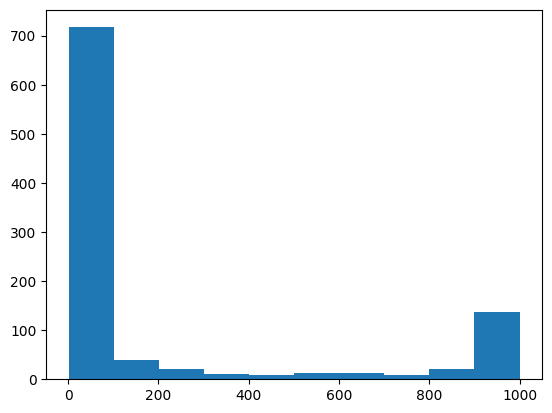

In [58]:
# distribution of len(set())

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

function_range = []
for output in outputs.values(): 
    function_range.append(len(set(output)))

print(np.mean(function_range))
print(np.std(function_range))
print(np.min(function_range))

plt.hist(function_range, bins=10)
plt.show()


In [59]:
to_ignore = []
for program_id, output in outputs.items(): 
    if len(set(output)) == 1: 
        to_ignore.append(program_id)

len(to_ignore)

563

458.9835294117647
430.3006524436439
2


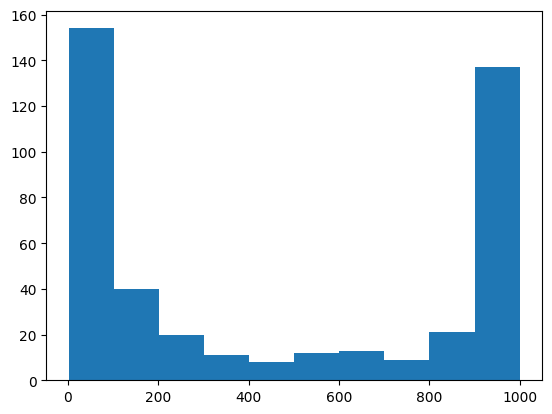

In [60]:
function_range = []
for program_id, output in outputs.items(): 
    if program_id not in to_ignore: 
        function_range.append(len(set(output)))

print(np.mean(function_range))
print(np.std(function_range))
print(np.min(function_range))

plt.hist(function_range, bins=10)
plt.show()


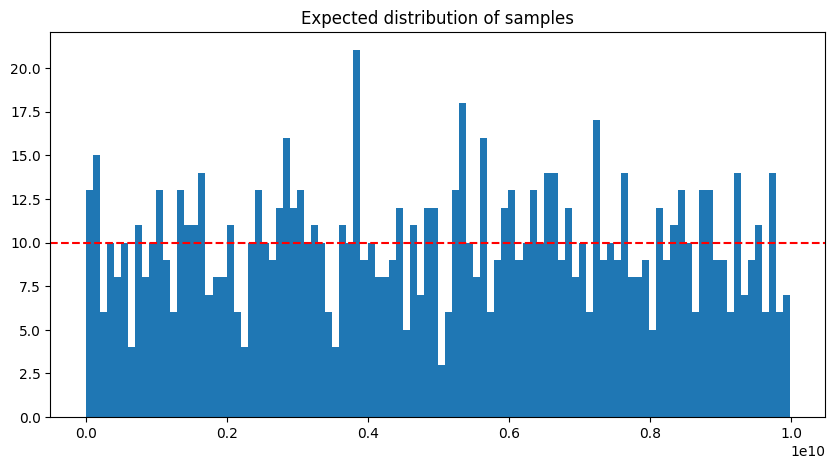

In [43]:
vocab = {0,1,2,3,4,5,6,7,8,9}
max_seq_len = 10
num_samples = 10**3
seed = 0
np.random.seed(seed)

samples = []
for i in range(num_samples): 
    r = np.random.randint(0, 10**10)
    samples.append(r)

# hist 
expected_per_bin = num_samples / 100
plt.figure(figsize=(10,5))
plt.hist(samples, bins=100)
plt.axhline(expected_per_bin, color='r', linestyle='--')
plt.title('Expected distribution of samples')
plt.show()

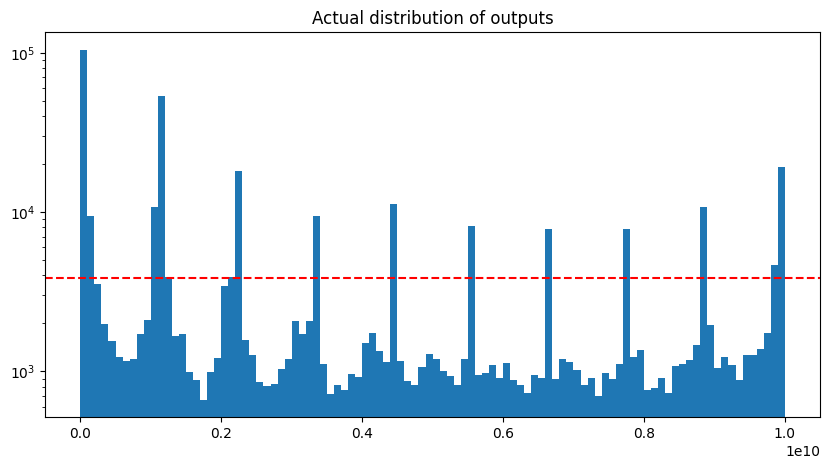

In [53]:
output_samples = []
for program_id, output in outputs.items(): 
    output = np.abs(np.array(output))
    output = output[output < 10**10]
    if program_id in to_ignore:
        continue
    output_samples.extend(output.tolist())


# ignore zeros 
plt.figure(figsize=(10,5))
plt.hist(output_samples, bins=100, range=(min(output_samples), max(output_samples)))
plt.yscale('log')
expected_per_bin = len(output_samples) / 100
plt.axhline(expected_per_bin, color='r', linestyle='--')
plt.title('Actual distribution of outputs')
plt.show()


In [22]:
# Calculate summary statistics
mean = np.mean(output_samples)
median = np.median(output_samples)
std_deviation = np.std(output_samples)
variance = np.var(output_samples)
minimum = np.min(output_samples)
maximum = np.max(output_samples)
count = len(output_samples)

print(f"Mean: {mean}")
print(f"Median: {median}")
print(f"Standard Deviation: {std_deviation}")
print(f"Variance: {variance}")
print(f"Minimum: {minimum}")
print(f"Maximum: {maximum}")
print(f"Count: {count}")

Mean: 381333943692.5595
Median: 203111104.0
Standard Deviation: 6459289039746.349
Variance: 4.172241489898731e+25
Minimum: 0
Maximum: 111109999988889
Count: 985453


In [23]:
from collections import Counter

count = Counter(output_samples)
count.most_common(10)

[(0, 453709),
 (9999999999, 98710),
 (1111111111, 88841),
 (2222222222, 15187),
 (5555555555, 12170),
 (3333333333, 11425),
 (8888888888, 9221),
 (4444444444, 7578),
 (7777777777, 5531),
 (6666666666, 5383)]

### check no two outputs are same

In [39]:
hashmap = {}
for program_id, output in outputs.items(): 
    to_hash = tuple(output)
    if to_hash not in hashmap: 
        hashmap[to_hash] = []
    hashmap[to_hash].append(program_id)

# sort by len of values
lens = [(key,len(value)) for key, value in hashmap.items()]
lens.sort(key=lambda x: x[1], reverse=True)
lens[10]

((9330293969,
  1966482153,
  3903390019,
  4930669038,
  10698541789,
  1053028031,
  10806492231,
  10189434269,
  1990633935,
  5132470323,
  2897698901,
  784806599,
  7545647709,
  9475787029,
  4284474372,
  9952433882,
  806840986,
  10585368198,
  5948727069,
  331734428,
  10215484689,
  4759044313,
  7000984477,
  6166170049,
  1517277679,
  5186508701,
  6517539968,
  9162346895,
  6867887360,
  9082830129,
  9476514061,
  10095832676,
  2783536757,
  5219203793,
  2248507415,
  1603199102,
  9031011979,
  6623285156,
  9201439509,
  1909762687,
  6352283120,
  6596729395,
  9979409038,
  4496470871,
  1726233096,
  6225510401,
  94816368,
  7272817221,
  10849534791,
  11178129216,
  10288229422,
  767635023,
  4136082396,
  57511775,
  4820517840,
  7729089698,
  7028087621,
  7056335087,
  8966726765,
  6784513095,
  6082492389,
  7682201391,
  4912821872,
  2780487167,
  10904676278,
  10631280697,
  1536133818,
  4065137616,
  9053288935,
  5691433099,
  4886523998,
  9